In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 9]
import rpy2.robjects as robjects

from rpy2.robjects.packages import importr
%load_ext rpy2.ipython



The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [13]:
df = pd.read_pickle('data/prop_data_gap_12_2_1_05_ct_NEST.pkl').drop_duplicates()

In [91]:
# --------- FILTERING ------------
reps_discarded = [20,41]
exp = 'DIA'

time_win = 2 #h
max_gap = 10 #s

df_filt = df.loc[(df.time_win==3600 * time_win) & 
                 (df.max_gap==max_gap) & 
                (df.exp.isin([exp+'a',exp+'b'])) & 
                (~df.rep.isin(reps_discarded))]
df_filt.insert(4,'h', [int(str(a)[-8:-6]) for a in df_filt.start])
df_filt = df_filt.sort_values(['rep','h'])

rep_to_colony = {i: i for i in range(57)}
#df_filt.insert(5, 'colony', [rep_to_colony[j] for j in df_filt.rep])

# Export dataframe for stats
df_filt.to_csv('NTM_df_stats.csv')
df_filt


,rep,exp,start,time_win,h,max_gap,CC,ants,partition,MOD,DEN,wDEN,DIA,wDIA,RAD,wRAD,DEH,wDEH,CLS
211,16,DIAa,2021-09-15 09:00:00,7200,9,10,25,177,6,0.338874,0.514018,0.003843,4,5.015169,2,3.0,35.325692,3858.981626,0.00719
242,16,DIAb,2021-09-13 09:00:00,7200,9,10,19,184,6,0.53724,0.336692,0.003741,5,1.958573,3,1.2,31.591997,4475.669993,0.007292
212,16,DIAa,2021-09-15 11:00:00,7200,11,10,25,177,8,0.361164,0.449174,0.003619,4,1.451373,2,1.0,31.71817,3943.732943,0.007229
243,16,DIAb,2021-09-13 11:00:00,7200,11,10,22,184,5,0.413516,0.385897,0.003687,4,3.835064,3,3.0,31.732269,4127.040769,0.0088
213,16,DIAa,2021-09-15 13:00:00,7200,13,10,24,177,7,0.440986,0.362957,0.003303,4,2.426591,2,1.217192,30.128333,3737.614572,0.00979
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2477,53,DIAb,2021-12-17 15:00:00,7200,15,10,12,165,5,0.416639,0.545794,0.005988,3,0.912137,2,0.75,29.531899,4552.745997,0.007623
2447,53,DIAa,2021-12-19 17:00:00,7200,17,10,9,164,6,0.413537,0.589495,0.005681,3,0.34448,2,0.181818,32.939186,4009.483296,0.009822
2478,53,DIAb,2021-12-17 17:00:00,7200,17,10,7,165,5,0.438883,0.488337,0.006228,4,0.815871,2,0.666667,31.590448,4678.545433,0.010144
2448,53,DIAa,2021-12-19 19:00:00,7200,19,10,6,164,5,0.414789,0.611814,0.006028,3,0.158208,2,0.080322,32.048443,3855.745739,0.00982


In [95]:
%%R -i time_win -o prop_list -o pv_adj 

# -----------------------------
# Linear Mixed Effects Model (R)
# -----------------------------
rm(list=ls())
library(lme4)
library(car)

prop_list <- c('MOD','wDIA','wDEH','wDEN')
dat <- read.csv("NTM_df_stats.csv",header=T,stringsAsFactors = F)
  # list of properties for the LMER test
pv_list <- integer(0)

print(dat$head)
if (dat$time_win[1] == 12*3600){rf = ' ~ exp +(1|rep)'}
    else{rf = ' ~ exp +(1|rep)+(1|h)'}

for (prop in prop_list){
    model <- lmer(formula(paste(prop,rf)), data = dat)
    print(summary(model))
    pv_list <- c(pv_list, print(as.numeric(Anova(model)["exp","Pr(>Chisq)"])))
}

pv_adj <- p.adjust(pv_list, method="BH")
names(pv_adj) <- prop_list

print(pv_adj)

NULL
Linear mixed model fit by REML ['lmerMod']
Formula: MOD ~ exp + (1 | rep) + (1 | h)
   Data: dat

REML criterion at convergence: -422.2

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.4373 -0.5423 -0.0624  0.5325  3.8499 

Random effects:
 Groups   Name        Variance  Std.Dev.
 rep      (Intercept) 7.522e-04 0.027425
 h        (Intercept) 4.837e-05 0.006955
 Residual             1.828e-03 0.042755
Number of obs: 132, groups:  rep, 11; h, 6

Fixed effects:
             Estimate Std. Error t value
(Intercept)  0.375985   0.010205  36.844
expDIAb     -0.001983   0.007443  -0.267

Correlation of Fixed Effects:
        (Intr)
expDIAb -0.365
[1] 0.7898541
Linear mixed model fit by REML ['lmerMod']
Formula: wDIA ~ exp + (1 | rep) + (1 | h)
   Data: dat

REML criterion at convergence: 612.4

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.9366 -0.5345 -0.1883  0.3179  4.2541 

Random effects:
 Groups   Name        Variance Std.Dev.
 rep      (Intercept) 1.

R[write to console]: boundary (singular) fit: see ?isSingular



Linear mixed model fit by REML ['lmerMod']
Formula: wDEH ~ exp + (1 | rep) + (1 | h)
   Data: dat

REML criterion at convergence: 1976.3

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.9887 -0.7269  0.1098  0.6613  2.5451 

Random effects:
 Groups   Name        Variance Std.Dev.
 rep      (Intercept) 244034   494.0   
 h        (Intercept)      0     0.0   
 Residual             176129   419.7   
Number of obs: 132, groups:  rep, 11; h, 6

Fixed effects:
            Estimate Std. Error t value
(Intercept)  3999.91     157.65  25.372
expDIAb       267.88      73.06   3.667

Correlation of Fixed Effects:
        (Intr)
expDIAb -0.232
optimizer (nloptwrap) convergence code: 0 (OK)
boundary (singular) fit: see ?isSingular

[1] 0.0002456034
Linear mixed model fit by REML ['lmerMod']
Formula: wDEN ~ exp + (1 | rep) + (1 | h)
   Data: dat

REML criterion at convergence: -1528.3

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-2.09857 -0.56131  0.00712  0.5573

In [93]:
pv_dict = {prop_list[i]: pv_adj[i] for i in range(len(pv_adj))}
pv_dict

{'MOD': 0.7898540597476782,
 'wDIA': 0.05928559354668137,
 'wDEH': 0.0009824136303680506,
 'wDEN': 0.7898540597476782}

/tmp/ipykernel_5468/3052687015.py:32: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  stat_sign = '*' + (pv_dict[p]<=0.01)*'*' + (pv_dict[p]<=0.001)*'*' + (pv_dict[p]<=0.0001)*'*'


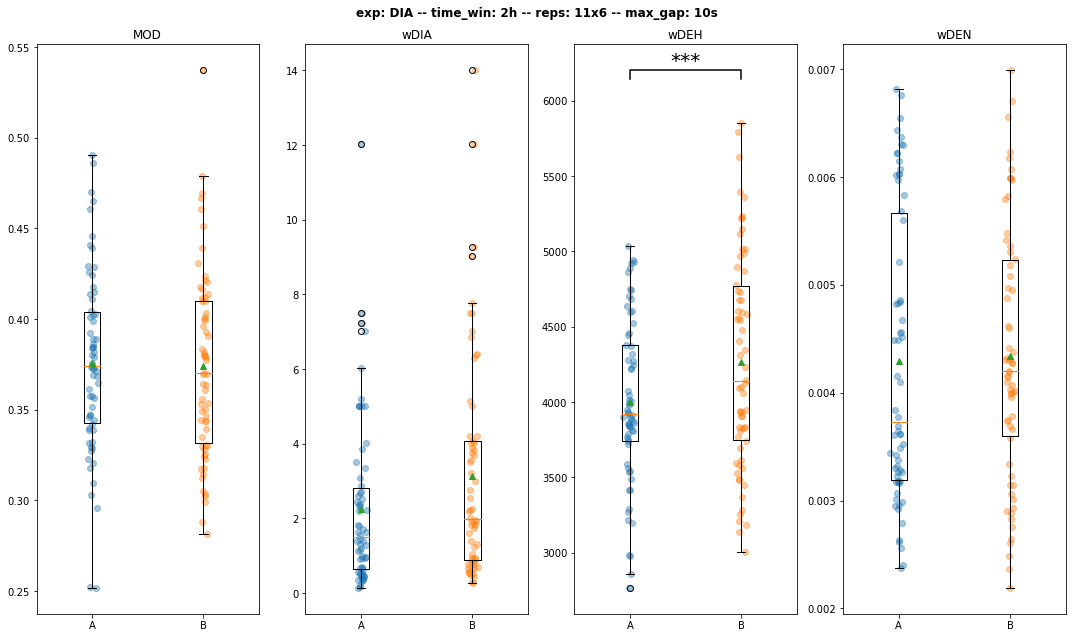

In [94]:
# Raw data specific property
fig, axs = plt.subplots(1, len(prop_list))

for idx_p, p in enumerate(prop_list):

    # dataframe for a-b comparison
    df_ab = pd.DataFrame()
    df_ab.insert(0, 'A', list(df_filt[p].iloc[::2]))
    df_ab.insert(1, 'B', list(df_filt[p].iloc[1::2]))
    df_ab


    # Plotting
    vals, names, xs = [],[],[]
    for i, col in enumerate(df_ab.columns):
        vals.append(df_ab[col].values)
        names.append(col)
        xs.append(np.random.normal(i + 1, 0.02, df_ab[col].values.shape[0]))  # adds jitter to the data points - can be adjusted


    box_plot = axs[idx_p].boxplot(vals, labels=names, showmeans=True)
    for x, val in zip(xs, vals):
        axs[idx_p].scatter(x, val, alpha=0.4)

    means = df_ab.mean()
    stds =  df_ab.std()
    
    axs[idx_p].set_title(p)
    
    # statistical annotation
    if pv_dict[p]<=0.05:
        stat_sign = '*' + (pv_dict[p]<=0.01)*'*' + (pv_dict[p]<=0.001)*'*' + (pv_dict[p]<=0.0001)*'*'
        x1, x2 = 1, 2   # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
        mm =np.max(df_ab.max())
        y, h, col = 1.05*mm, 0.01*mm, 'k'
        axs[idx_p].plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
        axs[idx_p].text((x1+x2)*.5, y+h, stat_sign, ha='center', va='bottom', color=col, fontsize=20)

fig = plt.suptitle('exp: ' + exp + 
                    ' -- time_win: ' + str(time_win) + 'h'
                    ' -- reps: ' + str(int(len(df_ab)*time_win/12)) + 'x' + str(int(12/time_win)) + 
                    ' -- max_gap: ' + str(max_gap) + 's',
                   fontweight="bold")
plt.tight_layout()
plt.show()

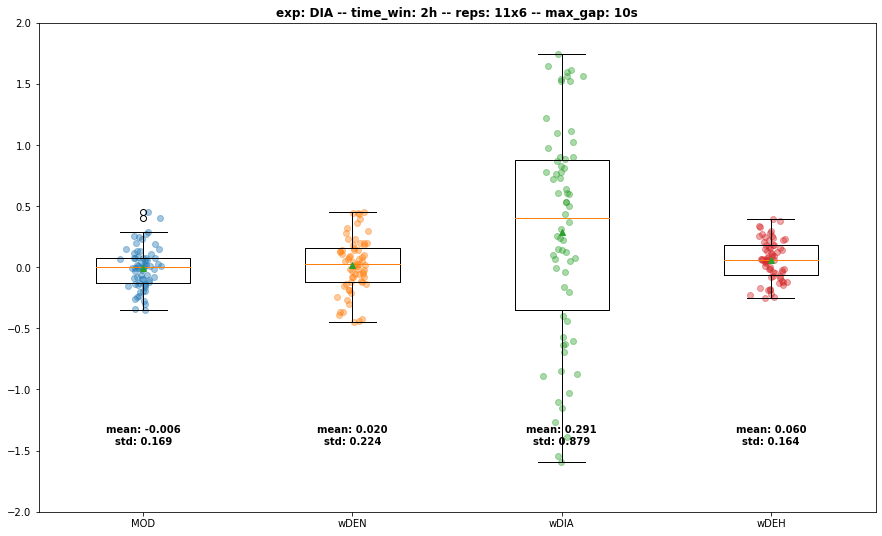

In [9]:
#===== RELATIVE DIFFERENCE =====


# ---- dataframe of relative difference---- 
p = ['MOD', 'wDEN', 'wDIA', 'wDEH']
df_rd = (df_filt[p].diff()/df_filt[p].rolling(2).mean()).iloc[1::2]
df_rd.insert(0,'rep', df_filt.rep.iloc[1::2])
df_rd.insert(1,'exp', [a[0:3] for a in df_filt.exp.iloc[1::2]])
df_rd.insert(3,'start-b', list(df_filt.start.iloc[1::2]))

vals, names, xs = [],[],[]
for i, col in enumerate(df_rd[p].columns):
    vals.append(df_rd[col].values)
    names.append(col)
    xs.append(np.random.normal(i + 1, 0.04, df_rd[col].values.shape[0]))  # adds jitter to the data points - can be adjusted

plt.figure()
box_plot = plt.boxplot(vals, labels=names, showmeans=True)
for x, val in zip(xs, vals):
    plt.scatter(x, val, alpha=0.4)

means = df_rd[p].mean()
stds =  df_rd[p].std()

for xtick in range(len(p)):
    plt.text(xtick+1,-1.35, 'mean: {:.3f}'.format(means[xtick]), 
              horizontalalignment='center',size='medium',color='k',weight='semibold')
    plt.text(xtick+1,-1.45, 'std: {:.3f}'.format(stds[xtick]), 
                  horizontalalignment='center',size='medium',color='k',weight='semibold')

plt.ylim([-2,2])
fig = plt.title('exp: ' + exp + 
                ' -- time_win: ' + str(time_win) + 'h'
                ' -- reps: ' + str(int(len(df_rd)*time_win/12)) + 'x' + str(int(12/time_win)) + 
                ' -- max_gap: ' + str(max_gap) + 's',
               fontweight="bold")